# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# import Agent from ddpg_agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from ddpg_agent import Agent

### Training Tennis Agent
The training function will train a pair of agents to play tennis.
The rewards will be added up for max time steps and it will yields 2 scores. we then take the maximum of these 2 scores.
After each episode, it will be stored to 'scores' variable and be averaged over 100 episodes.
The environment is considered solved, when the average of scores is at leat +0.5


In [8]:
def ddpg_tennis(n_episodes=1000, max_t=1000, print_every=100):
    """
    Training a pair of agents
    
    Arguments:
        n_episodes - number of episodes
        max_t - max time steps
        print_every - print every 'print_every' step
    
    Returns:
        scores - the list of each episode score
        ma_scores - moving average score over 'print_every', 100 episodes
    """
    scores_deque = deque(maxlen=print_every)
    scores, ma_scores = [], []
    achieved = False

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations            # get the current state
        episode_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)          # select an action
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones) # take step with agent (including learning)
            episode_scores += rewards                                # update the score
            states = next_states                             # roll over the state to next time step
            if np.any(dones):                                       # exit loop if episode finished
                break
        
        scores_deque.append(np.max(episode_scores))       # save most recent score
        scores.append(np.max(episode_scores))
        ma_scores.append(np.mean(scores_deque)) # Moving average socres over 100 episodes

        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_deque)>=0.5 and achieved is False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            achieved = True 
            
    return scores, ma_scores

### Create the Agent

In [9]:
# Create Agent
random_seed = 10
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=random_seed)

### Train the agent
n_episodes is set to 3000, print step and number of episodes to take an average is set to 100

In [10]:
scores, avg_scores = ddpg_tennis(n_episodes=3000, print_every=100)

Episode 100	Average Score: 0.0000
Episode 200	Average Score: 0.0148
Episode 300	Average Score: 0.0246
Episode 400	Average Score: 0.0136
Episode 500	Average Score: 0.0686
Episode 600	Average Score: 0.0739
Episode 700	Average Score: 0.0693
Episode 800	Average Score: 0.0698
Episode 897	Average Score: 0.5174
Environment solved in 897 episodes!	Average Score: 0.5174
Episode 900	Average Score: 0.5684
Episode 1000	Average Score: 1.6028
Episode 1100	Average Score: 1.8679
Episode 1200	Average Score: 1.1268
Episode 1300	Average Score: 1.0198
Episode 1400	Average Score: 1.4832
Episode 1500	Average Score: 1.1084
Episode 1600	Average Score: 1.0127
Episode 1700	Average Score: 1.1246
Episode 1800	Average Score: 0.8653
Episode 1900	Average Score: 0.9978
Episode 2000	Average Score: 1.1338
Episode 2100	Average Score: 0.8255
Episode 2200	Average Score: 1.6007
Episode 2300	Average Score: 0.7920
Episode 2400	Average Score: 1.3737
Episode 2500	Average Score: 1.5988
Episode 2600	Average Score: 1.3809
Episode

### Plot scores and moving average scores over epsiodes

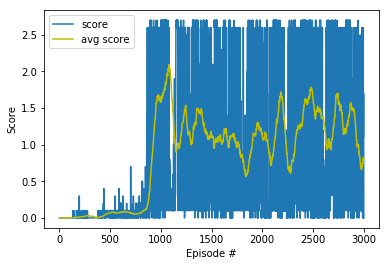

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='score')
plt.plot(np.arange(1, len(scores)+1), avg_scores, c='y', label='avg score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

In [12]:
env.close()

### Find out what is the maximum average score in which episode 

In [13]:
print("max average score=", max(avg_scores), "in", np.argmax(avg_scores) + 1, "episode")

max average score= 2.095000031217933 in 1083 episode
